In [1]:
%matplotlib notebook
import os, sys
import logging
import random
import h5py
import shutil
import time
import argparse
import numpy as np
import sigpy.plot as pl
import torch
import sigpy as sp
import torchvision
from torch import optim
import scipy.ndimage
from scipy.ndimage import binary_closing
from tensorboardX import SummaryWriter
from torch.nn import functional as F
import torch.nn as nn
from torch.utils.data import DataLoader
import matplotlib
# import custom libraries
from utils import transforms as T
from utils import subsample as ss
from utils import complex_utils as cplx
from utils.resnet2p1d import generate_model
from utils.flare_utils import roll
from utils import data_ut as dut
# import custom classes
from utils.datasets import SliceData
from subsample_fastmri import MaskFunc
from MoDL_single import UnrolledModel
import argparse
import matplotlib.pyplot as plt
%matplotlib inline
import nibabel as nib
from models.SAmodel import MyNetwork
from models.Unrolled import Unrolled
from ImageFusion_Dualbranch_Fusion.densefuse_net import DenseFuseNet
from ImageFusion_Dualbranch_Fusion.channel_fusion import channel_f as channel_fusion

from RCAN import CombinedNetwork
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
%load_ext autoreload
%autoreload 0

dict_keys(['__header__', '__version__', '__globals__', 'T1rho', 'bSSFP'])
Read the key  bSSFP
(64, 69, 21)


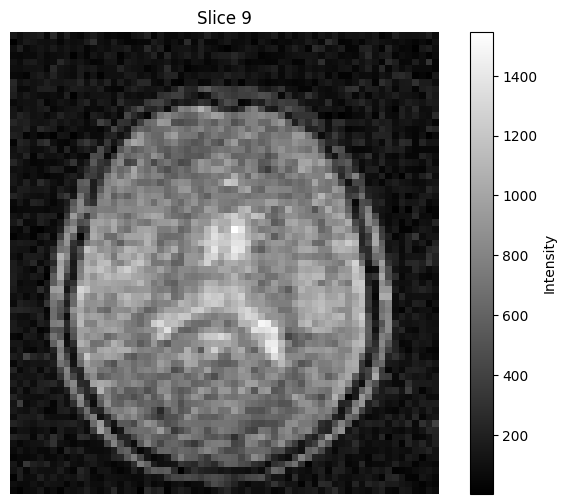

'\n# Plot slices in the specified range\nstart_slice = 5\nend_slice = 15\n\nfig, axes = plt.subplots(2, 6, figsize=(18, 8))  # Adjust grid size based on the number of slices\naxes = axes.flatten()\n\nfor i, slice_num in enumerate(range(start_slice, end_slice + 1)):\n    slice_data = data[:, :, slice_num]\n    ax = axes[i]\n    ax.imshow(np.abs(slice_data), cmap=\'gray\')\n    ax.set_title(f"Slice {slice_num}")\n    ax.axis(\'off\')  # Turn off axes for cleaner visuals\n\n# Hide unused subplots if any\nfor j in range(i + 1, len(axes)):\n    axes[j].axis(\'off\')\n\nplt.tight_layout()\nplt.show()\n'

In [2]:
from scipy.io import loadmat

# Load the .mat file
mat_file = "./EfratData/bSSFP_T1rho_brain_scans_6.5mT.mat"
mat_data = loadmat(mat_file)
print(mat_data.keys())
key_name = 'bSSFP'  # Replace with the actual key name
if key_name in mat_data:
    data = mat_data[key_name]
    print("Read the key ", key_name)
else:
    print(f"Key '{key_name}' not found in the .mat file.")

print(data.shape)
slice_num = 9
slice_data = np.rot90(data[:,:,slice_num],-1)

# Plot the slice
plt.figure(figsize=(8, 6))
plt.imshow(np.abs(slice_data), cmap='gray')  # Use 'gray' colormap for MRI images
plt.title(f"Slice {slice_num}")
plt.colorbar(label='Intensity')
plt.axis('off')  # Optional: Turn off axes for a cleaner plot
plt.show()

"""
# Plot slices in the specified range
start_slice = 5
end_slice = 15

fig, axes = plt.subplots(2, 6, figsize=(18, 8))  # Adjust grid size based on the number of slices
axes = axes.flatten()

for i, slice_num in enumerate(range(start_slice, end_slice + 1)):
    slice_data = data[:, :, slice_num]
    ax = axes[i]
    ax.imshow(np.abs(slice_data), cmap='gray')
    ax.set_title(f"Slice {slice_num}")
    ax.axis('off')  # Turn off axes for cleaner visuals

# Hide unused subplots if any
for j in range(i + 1, len(axes)):
    axes[j].axis('off')

plt.tight_layout()
plt.show()
"""

In [24]:
## Read 3T scan
# Import necessary functions
from raw_kspace_recon.utils import read_raw_twix_data, DimensionType

# Define the path to your .dat file
dat_file_path = 'EfratData/3Tkspace/SER00012/UNWRAP/meas_MID00093_FID09382_t2_trufi3d_we_tra_320.dat'

# Read and process 2D data
image_2d, data_2d = read_raw_twix_data(dat_file_path, type=DimensionType.TWO_D)


         Setting keep_syncdata and keep_acqend to {True}.
Software version: VD/VE (!?)

Scan  0


100%|██████████| 11.3M/11.3M [00:00<00:00, 128MB/s]


Scan  1


 14%|█▎        | 89.1M/648M [00:00<00:01, 470MB/s]

100%|██████████| 648M/648M [00:02<00:00, 334MB/s] 


Dimensions: ['Par', 'Lin', 'Cha', 'Col']
image shape (44, 328, 252)


(44, 328, 252)


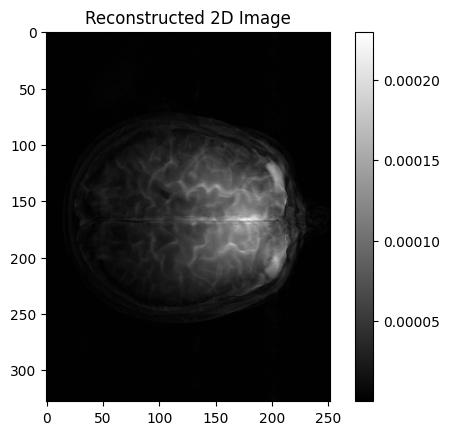

In [20]:
print(image_2d.shape)
# Display the resulting image
plt.imshow(image_2d[25, :, :], cmap='gray')
plt.title('Reconstructed 2D Image')
plt.colorbar()
plt.show()

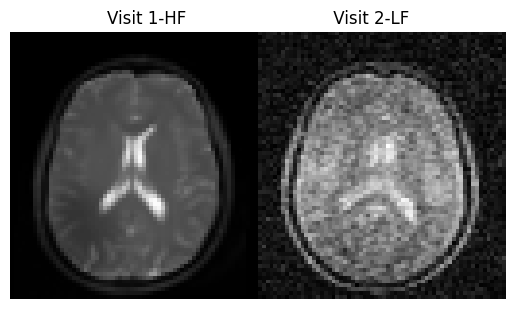

In [8]:
import pydicom
import matplotlib.pyplot as plt


# Load the nii files
nifti_file_HF = "./EfratData/HFEfratregULFEfrat.nii"
nifti_file_LF = "./EfratData/ULFEfratreg.nii"
nifti_data_HF = nib.load(nifti_file_HF)
nifti_data_LF = nib.load(nifti_file_LF)

# Extract the image data
image_data_HF = nifti_data_HF.get_fdata()
image_data_LF = nifti_data_LF.get_fdata()

concat = np.concatenate((image_data_HF[0,:,:],image_data_LF[0,:,:]),axis=1)
# Plot the image
plt.imshow(concat, cmap="gray")
plt.title("Visit 1-HF                            Visit 2-LF")
plt.axis("off")
plt.show()

In [6]:
!pwd

/home/tal/docker/MoDLsinglechannel/modl_singlechannel_reference


In [7]:
!which python3

/bin/python3


In [26]:

# Path to your NIfTI file
# Sairam data
nii_file_target = './reg_data_sairam/ULF4reg.nii'
nii_file_ref = './reg_data_sairam/HF4regULF4.nii'

# Padding size
# Desired size
target_height, target_width = 172, 108

# Calculate padding for each side
pad_height = target_height - 69
pad_width = target_width - 64

top = pad_height // 2
bottom = pad_height - top
left = pad_width // 2
right = pad_width - left

size1 = 69
size2 = 64

image_data_HF = nifti_data_HF.get_fdata()
image_data_LF = nifti_data_LF.get_fdata()
#target = img_target.get_fdata()[...,20]
#reference = img_ref.get_fdata()[...,20]
padded_HF = np.pad(image_data_HF[0,:,:], ((top, bottom), (left, right)), mode='constant', constant_values=0)

padded_LF = np.pad(image_data_LF[0,:,:], ((top, bottom), (left, right)), mode='constant', constant_values=0)


target = torch.from_numpy(np.expand_dims(padded_LF,0))
reference = padded_HF
# Padding
print(f'Target shape: {target.shape}')
print(f'Reference shape: {reference.shape}')

"""
target = F.pad(target.unsqueeze(0).unsqueeze(0), (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0).squeeze(0).squeeze(0).numpy() 
reference = F.pad(reference.unsqueeze(0).unsqueeze(0), (pad_left, pad_right, pad_top, pad_bottom), mode='constant', value=0).squeeze(0).squeeze(0).numpy() 
"""

random_phase = torch.angle(T.random_map((1,172,108), 'cpu',kspace_radius_range=(0.001, 0.001))) 
target = target * (torch.exp(1j * random_phase)).numpy() 
target = target.squeeze(0)
target_torch = cplx.to_tensor(target).float() 
reference_torch = cplx.to_tensor(reference).float()


reference_kspace_torch = T.fft2(reference_torch)
reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_kspace_torch = T.kspace_cut(reference_kspace_torch, 0.67,0.67)
#reference_kspace = cplx.to_numpy(reference_kspace_torch)
#reference_torch = T.ifft2(reference_kspace_torch)
#reference = cplx.to_numpy(reference_torch)
kspace_torch = T.fft2(target_torch)
#kspace_torch = T.kspace_cut(kspace_torch, 0.67,0.67)
#target_torch = T.ifft2(kspace_torch)
target = cplx.to_numpy(target_torch)
kspace = cplx.to_numpy(kspace_torch)
# Print the shape of the data to verify
print(target_torch.shape)

kspace_torch = T.awgn_torch(kspace_torch,1000,L=1)
kspace_torch = T.kspace_crop(kspace_torch,0.67)

print(kspace_torch.shape)


"""
data_R1 = np.load('../../T1w_T2w_R1_R2/data_T1w_IR_R1.npy')
data_full = np.fft.fftshift(np.fft.fftn((np.fft.fftshift(data_R1))))
slice_full = data_full[:,15:123,10]
target_height = 172
target_width = 108

# Calculate padding for height (top and bottom)
padding_top = (target_height - slice_full.shape[0]) // 2
padding_bottom = target_height - slice_full.shape[0] - padding_top

# Pad the array with zeros
slice_full = np.pad(slice_full, ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)

kspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(slice_full)), norm='ortho'))
target = np.fft.fftshift(np.fft.ifft2((np.fft.ifftshift(kspace)), norm='ortho'))

reference = np.pad(data_full[:,15:123,11], ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)
reference_kspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(reference)), norm='ortho'))

fig, axs = plt.subplots(1, 1, figsize=(5, 5))
concat = np.concatenate((target,reference),axis =1 )
im1 = axs.imshow(np.abs(concat), cmap='gray') #np.log(np.abs(kspace))np.abs(slice_full)
plt.title('LF data')
plt.axis('off')
plt.show()
print(slice_full.shape)

"""

Target shape: torch.Size([1, 172, 108])
Reference shape: (172, 108)
torch.Size([172, 108, 2])
torch.Size([172, 108, 2])


"\ndata_R1 = np.load('../../T1w_T2w_R1_R2/data_T1w_IR_R1.npy')\ndata_full = np.fft.fftshift(np.fft.fftn((np.fft.fftshift(data_R1))))\nslice_full = data_full[:,15:123,10]\ntarget_height = 172\ntarget_width = 108\n\n# Calculate padding for height (top and bottom)\npadding_top = (target_height - slice_full.shape[0]) // 2\npadding_bottom = target_height - slice_full.shape[0] - padding_top\n\n# Pad the array with zeros\nslice_full = np.pad(slice_full, ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)\n\nkspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(slice_full)), norm='ortho'))\ntarget = np.fft.fftshift(np.fft.ifft2((np.fft.ifftshift(kspace)), norm='ortho'))\n\nreference = np.pad(data_full[:,15:123,11], ((padding_top, padding_bottom), (0, 0)), mode='constant', constant_values=0)\nreference_kspace = np.fft.fftshift(np.fft.fft2((np.fft.ifftshift(reference)), norm='ortho'))\n\nfig, axs = plt.subplots(1, 1, figsize=(5, 5))\nconcat = np.concatenate((target,refe

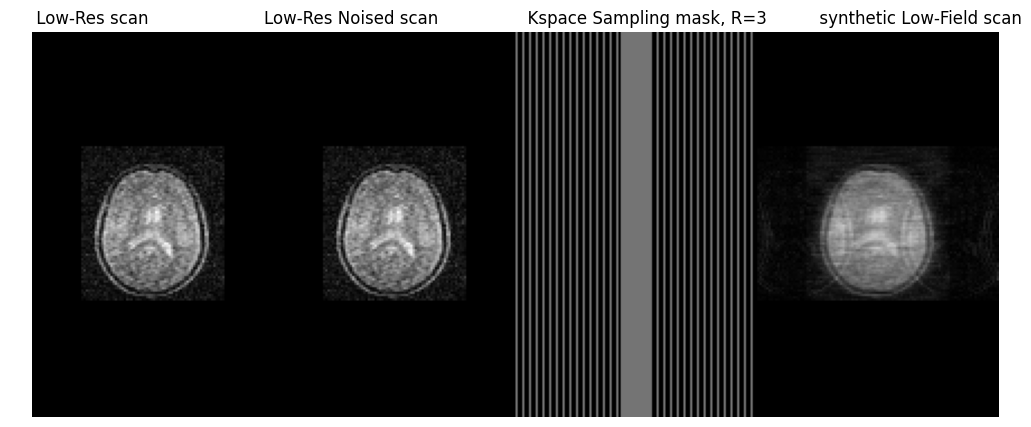

torch.Size([172, 108, 2])
torch.Size([172, 108, 2])


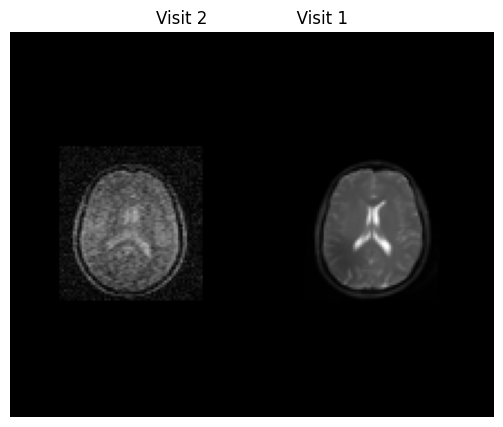

Mask torch size: (172, 108)
Acceleration factor R: 0.4166666666666667


In [27]:
im_lowres = abs(sp.ifft(sp.resize(sp.resize(kspace,(155,24)),(155,155))))
magnitude_vals = im_lowres.reshape(-1)
k = int(round(0.05 * magnitude_vals.shape[0]))
scale = magnitude_vals[magnitude_vals.argsort()[::-1][k]]
kspace = kspace/scale
target = target/scale

# Apply kspace crop on target
target_torch = cplx.to_tensor(target)
target_torch = T.ifft2( T.fft2(target_torch))
# For plot
kspace_HR = np.abs(cplx.to_numpy(T.fft2(cplx.to_tensor(target))))
kspace_LR =cplx.to_numpy( T.fft2( cplx.to_tensor(target)))
target_HR = target
target_LR = cplx.to_numpy(T.ifft2( T.kspace_crop(T.fft2( cplx.to_tensor(target)),0.67)))
target = cplx.to_numpy(target_torch)
# Convert everything from numpy arrays to tensors
kspace_torch = cplx.to_tensor(kspace).float()
kspace_torch = T.awgn_torch(kspace_torch,1000,L=1)
kspace_noised = kspace_torch.clone()
target_torch = cplx.to_tensor(target).float()

### Reference addition ###
im_lowres_ref = abs(sp.ifft(sp.resize(sp.resize(reference_kspace,(172,24)),(172,108))))
magnitude_vals_ref = im_lowres_ref.reshape(-1)
k_ref = int(round(0.05 * magnitude_vals_ref.shape[0]))
scale_ref = magnitude_vals_ref[magnitude_vals_ref.argsort()[::-1][k_ref]]
reference = reference / scale_ref
reference_torch = cplx.to_tensor(reference).float()
reference_torch_kspace = T.fft2(reference_torch)
reference_torch = T.ifft2(reference_torch_kspace)
"""
fig, axs = plt.subplots(1, 1, figsize=(5, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(cplx.to_numpy(mask_torch)), cmap='gray')
plt.show()
"""
#kspace_torch = kspace_torch*mask_torch

from fastmri.data import transforms, subsample
def get_mask_func(factor):
    center_fractions = 0.1 * 4/factor # RandomMaskFuncEquiSpacedMaskFunc
    mask_func = subsample.EquiSpacedMaskFunc(
    center_fractions=[center_fractions],
    accelerations=[factor], 
    )
    return mask_func
mask_func = get_mask_func(3)
kspace_torch = transforms.apply_mask(kspace_torch, mask_func)[0]

concat = np.concatenate((target,cplx.to_numpy(T.ifft2(kspace_noised)),np.abs(cplx.to_numpy(kspace_torch))!=0,cplx.to_numpy(T.ifft2(kspace_torch))),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('     Low-Res scan                      Low-Res Noised scan                 Kspace Sampling mask, R=3          synthetic Low-Field scan')
plt.axis('off')
plt.show()

fig, axs = plt.subplots(1, 1, figsize=(10, 5))  # 1 row, 3 columns
print(target_torch.shape)
print(reference_torch.shape)

concat2 = np.concatenate((cplx.to_numpy(target_torch),cplx.to_numpy(reference_torch)),axis=1)
im1 = axs.imshow(np.abs(concat2), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title('Visit 2                 Visit 1')
plt.axis('off')
plt.show()
"""
concat = np.concatenate((target_HR,target_LR),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.abs(concat), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title(' High-Res scan (1x1[mm])        Low-Res scan (1.5x1.5[mm])   ')
plt.axis('off')
plt.show()

concat = np.concatenate((kspace_HR,kspace_LR),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(6, 5))  # 1 row, 3 columns
# Plot each image in a subplot
im1 = axs.imshow(np.log(np.abs(concat)), cmap='gray')
#im1 = axs.imshow(np.log(np.abs(cplx.to_numpy(kspace_torch))), cmap='gray')
plt.title(' High-Res kspace (1x1[mm])        Low-Res kspace (1.5x1.5[mm])   ')
plt.axis('off')
plt.show()
"""
mask_np = np.abs(cplx.to_numpy(kspace_torch))!=0
print(f'Mask torch size: {mask_np.shape}')
s = (172)*(108)
print(f'Acceleration factor R: {np.sum(mask_np)/s}')

In [28]:
class Namespace:
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

In [29]:
#Hyper parameters
params = Namespace()
#params.data_path = "./registered_data/patient23b/"
params.data_path = "./registered_data/"
params.batch_size = 2
params.num_grad_steps = 1 #4
params.num_cg_steps = 8 #8
params.share_weights = True
params.modl_lamda = 0.05
params.lr = 0.00001
#params.lr = 0.0001
params.weight_decay = 0
params.lr_step_size = 7
params.lr_gamma = 0.1
params.epoch = 61
params.reference_mode = 1
params.reference_lambda = 0.1

In [30]:

checkpoint_file = "./L2_checkpoints_Sairam/model_40.pt" 
checkpoint_file_fuser = "./L2_checkpoints_Sairam_fuser/model_40.pt" 

checkpoint = torch.load(checkpoint_file,map_location=device)
checkpoint_fuser = torch.load(checkpoint_file_fuser,map_location=device)
# Init model
from vision_transformer import VisionTransformer
from recon_net import ReconNet

#from UnrolledViT import UnrolledViT
from UnrolledViT import UnrolledViT
model = UnrolledViT(params).to(device)
model_fuser = UnrolledViT(params).to(device)

# load checkpoint
#cp = torch.load('./lsdir-2x+hq50k_vit_epoch_60.pt', map_location=device)
#checkpoint_file = "./L2_checkpoints_poisson_x2_FusionNetViT/model_30.pt"
model.load_state_dict(checkpoint['model'])
model_fuser.load_state_dict(checkpoint_fuser['model'])


shared weights
shared weights


<All keys matched successfully>

torch.Size([1, 1, 172, 108])
torch.Size([172, 108, 2])
torch.Size([172, 108, 2])
torch.Size([172, 108, 1])
torch.Size([172, 108, 2])
(172, 108)


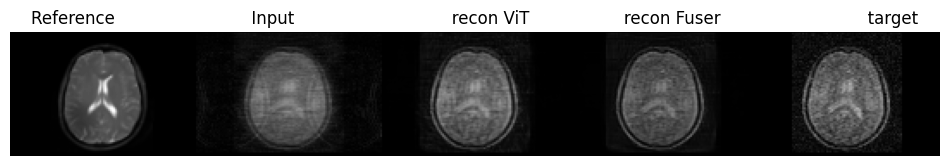

In [40]:


img = cplx.to_tensor(np.abs(cplx.to_numpy(T.ifft2(kspace_torch)))).permute(2,0,1).unsqueeze(0).to(device)
img_chan = img[:,0,:,:].unsqueeze(0)
ref = cplx.to_tensor(np.abs(cplx.to_numpy(reference_torch))).permute(2,0,1).unsqueeze(0).to(device)
ref_chan = ref[:,0,:,:].unsqueeze(0)
ref_np = ref_chan.cpu().numpy()[0,0,:,:]
print(img_chan.shape)
img_padded_np = img_chan.cpu().numpy()[0,0,:,:]

## Regular
print(kspace_torch.shape)
print(reference_torch.shape)
im_out = model(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
print(im_out.shape)
im_out_pad = torch.cat((im_out,torch.zeros_like(im_out)),dim=2)
print(im_out_pad.shape)
im_out = T.ifft2(T.fft2(im_out_pad))
target_torch = T.ifft2(T.fft2(cplx.to_tensor(target)))
target = cplx.to_numpy(target_torch.cpu().detach())
#merged_np = im_out.cpu().detach().numpy()[0,:,:,:]
#im_out = np.sqrt(merged_np[:,:,0]**2 + merged_np[:,:,1]**2)
im_out = np.abs(cplx.to_numpy(im_out.cpu().detach()))
#im_out = 1-(np.abs(im_out)-np.abs(target))
print(im_out.shape)

## Fuser
im_out_fuser = model_fuser(kspace_torch.float().unsqueeze(0).to(device),reference_torch.float().unsqueeze(0).to(device)).squeeze(0)
im_out_fuser_pad = torch.cat((im_out_fuser,torch.zeros_like(im_out_fuser)),dim=2)
im_out_fuser = T.ifft2(T.fft2(im_out_fuser_pad))
im_out_fuser = np.abs(cplx.to_numpy(im_out_fuser.cpu().detach()))

st = 50
ed = 50
# Concatenate images horizontally
concatenated_image = np.concatenate((ref_np[st:-ed],img_padded_np[st:-ed], im_out[st:-ed], im_out_fuser[st:-ed],np.abs(target[st:-ed])),axis=1)
# Plot the concatenated image
plt.figure(figsize=(12, 6))
plt.imshow(concatenated_image, cmap='gray')
plt.title('Reference                          Input                              recon ViT                  recon Fuser                            target')
plt.axis('off')
plt.show()


In [32]:
kspace_torch.shape
reference_torch.shape

torch.Size([172, 108, 2])

(172, 108)


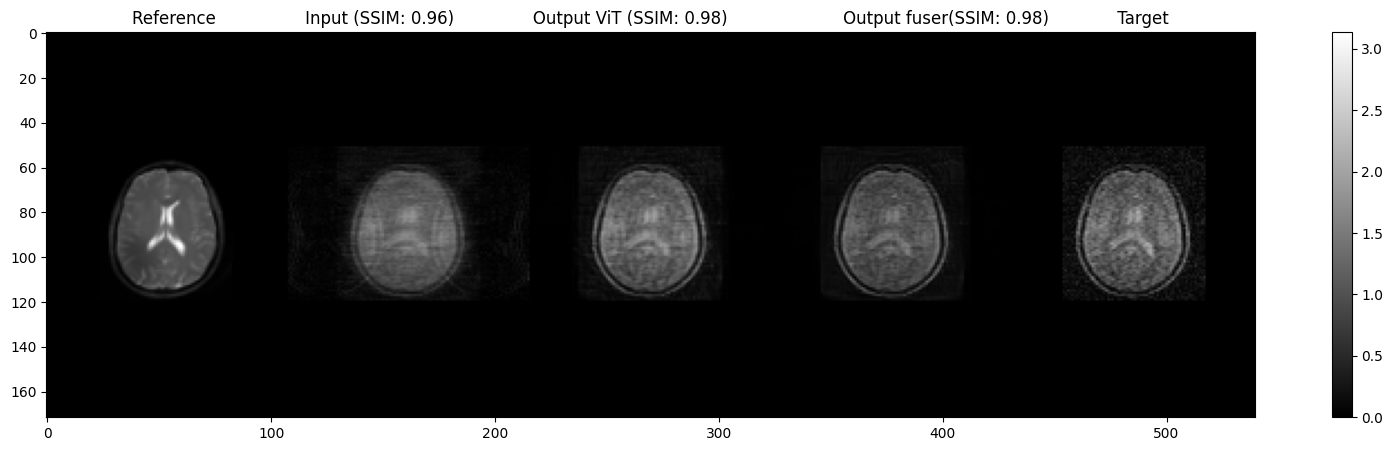

In [33]:
from skimage.metrics import structural_similarity as ssim
from scipy.ndimage import binary_fill_holes
def compute_psnr(img1, img2, maxval):
    """Computes PSNR in dB"""
    mse = np.mean((img1 - img2) ** 2)

    return (10 * np.log10(maxval / mse)).item()
cplx_image_target = target
cplx_image_in = img_padded_np
cplx_image_out = im_out
cplx_image_out_fuser = im_out_fuser

cplx_image_reference = ref_np
maxval = np.max(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out,cplx_image_out_fuser),axis=0)))
minval = np.min(np.abs(np.concatenate((cplx_image_target,cplx_image_in,cplx_image_out,cplx_image_out_fuser),axis=0)))

target_numpy_norm = np.abs(cplx_image_target)/maxval
input_numpy_norm = np.abs(cplx_image_in)/maxval
out_numpy_norm = np.abs(cplx_image_out)/maxval
out_fuser_numpy_norm = np.abs(cplx_image_out_fuser)/maxval

# Area calib
# Find comparison area:
area = target_numpy_norm > 0.30
kernel = np.ones((10, 10)) / 25.0
#area = np.convolve(area, kernel, mode='constant', cval=0.0)
area = scipy.ndimage.convolve(area.astype(float), kernel, mode='constant', cval=0.0)
area[area>0.009] = 1
structuring_element = np.ones((4,4))
area = binary_closing(area, structure=structuring_element)
area = binary_fill_holes(area)

target_numpy_norm = target_numpy_norm * area
input_numpy_norm = input_numpy_norm * area
out_numpy_norm = out_numpy_norm * area
out_fuser_numpy_norm = out_fuser_numpy_norm * area


psnr_in = compute_psnr(target_numpy_norm, input_numpy_norm,1)
psnr_out = compute_psnr(target_numpy_norm,out_numpy_norm,1)
data_range = maxval - minval
ssim_in, _ = ssim(target_numpy_norm, input_numpy_norm, data_range=data_range, full=True)
ssim_out, _ = ssim(target_numpy_norm, out_numpy_norm, data_range=data_range, full=True)
ssim_out_fuser, _ = ssim(target_numpy_norm, out_fuser_numpy_norm, data_range=data_range, full=True)

print(cplx_image_out.shape)
plt_concat = np.concatenate((np.abs(cplx_image_reference),np.abs(cplx_image_in),np.abs(cplx_image_out),np.abs(cplx_image_out_fuser),np.abs(cplx_image_target)),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(20, 5))  # 1 row, 3 columns
im = axs.imshow(plt_concat, cmap='gray')
axs.set_title(f'Reference                 Input (SSIM: {ssim_in:.2f})               Output ViT (SSIM: {ssim_out:.2f})                      Output fuser(SSIM: {ssim_out_fuser:.2f})             Target')
#axs.set_title(f'Reference                         Input                         Output                                 Target')
fig.colorbar(im, ax=axs)
plt.show()




(172, 108)
(172, 108)
(172, 108)


/tmp/ipykernel_2594682/566286739.py:11: RuntimeWarning: divide by zero encountered in log
  im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')


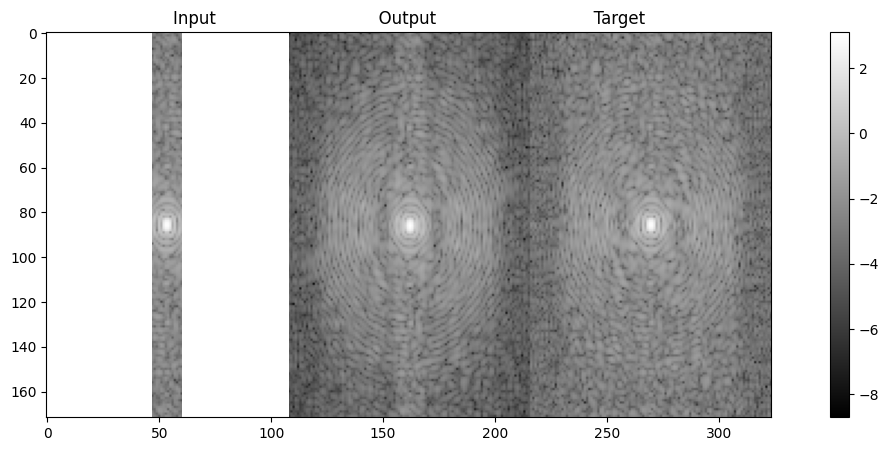

/tmp/ipykernel_2594682/566286739.py:16: RuntimeWarning: divide by zero encountered in log
  pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))
/home/tal/.local/lib/python3.10/site-packages/matplotlib/image.py:453: RuntimeWarning: invalid value encountered in double_scalars
  vmid = np.float64(self.norm.vmin) + dv / 2


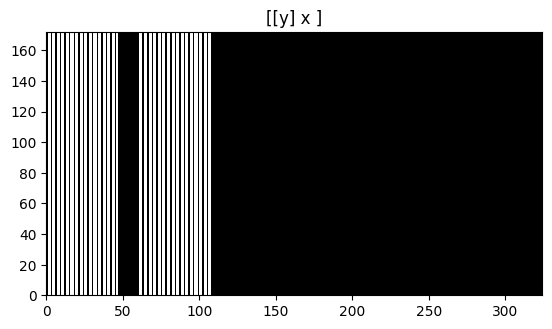

In [34]:

print(cplx_image_target.shape)
print(cplx_image_in.shape)
print(cplx_image_out.shape)
# Create a figure and axes
kspace_in = cplx.to_numpy(kspace_torch)
kspace_out = cplx.to_numpy(T.fft2((cplx.to_tensor(cplx_image_out))))
kspace_target = cplx.to_numpy(T.fft2((cplx.to_tensor(cplx_image_target))))

plt_concat = np.concatenate((kspace_in,kspace_out,kspace_target),axis=1)
fig, axs = plt.subplots(1, 1, figsize=(15, 5))  # 1 row, 3 columns
im = axs.imshow(np.log(np.abs(plt_concat)), cmap='gray')
axs.set_title('Input                               Output                              Target')
fig.colorbar(im, ax=axs)
plt.show()

pl.ImagePlot(np.log(np.abs(plt_concat).astype(float)))

In [35]:
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import copy

# pytorch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision.datasets import ImageFolder
from torchvision import models, transforms
import torchvision

model_ft = models.vgg16(weights='DEFAULT').requires_grad_(False)

In [36]:
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [37]:
#model_ft.fc = nn.Identity()
model.classifier = nn.Identity()
print(model_ft)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1